In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
import segmentation_models_pytorch as smp
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from thop import profile
import time

In [9]:
device = torch.device("cpu")
model_path = "../Fourth_training_phase/WE3DS/ENB0+UNet_models/WE3DS_seg_standard_DiceLoss.pth" 

In [3]:
model = smp.Unet(
    encoder_name="efficientnet-b0",
    encoder_weights="imagenet",
    in_channels=3,
    classes=19
)

In [4]:
model.load_state_dict(torch.load(model_path, map_location=device))
model.to(device)
model.eval()

/tmp/ipykernel_3932936/1481618732.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))


Unet(
  (encoder): EfficientNetEncoder(
    (_conv_stem): Conv2dStaticSamePadding(
      3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
      (static_padding): ZeroPad2d((0, 1, 0, 1))
    )
    (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (_blocks): ModuleList(
      (0): MBConvBlock(
        (_depthwise_conv): Conv2dStaticSamePadding(
          32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
          (static_padding): ZeroPad2d((1, 1, 1, 1))
        )
        (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_se_reduce): Conv2dStaticSamePadding(
          32, 8, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_se_expand): Conv2dStaticSamePadding(
          8, 32, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_project_conv): Conv2dStaticSamePadding

In [4]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),   # resizing
    transforms.ToTensor(),           # [0,1]
])

In [6]:
def load_class_info(colors_path, names_path):
    with open(colors_path, 'r') as f:
        class_colors = [list(map(int, line.strip().split(','))) for line in f]
    with open(names_path, 'r') as f:
        class_names = [line.strip() for line in f]
    return np.array(class_colors), class_names

class_colors, class_names = load_class_info(
    "../WE3DS-dataset/class_colors.txt",
    "../WE3DS-dataset/class_names.txt"
)

In [7]:
new_class_names  = ["soil", "common buckwheat", "weeds", "others"]
new_class_colors = np.array([
    [0, 0, 0],       # soil = nero
    [128, 0, 128],   # common buckwheat = viola
    [0, 255, 0],     # weeds = verde
    [192, 128, 0]    # others = arancione
])

In [13]:
orig_names = [
 "void","soil","broad bean","corn spurry","red-root amaranth","common buckwheat",
 "pea","red fingergrass","common wild oat","cornflower","corn cockle","corn",
 "milk thistle","rye brome","soybean","sunflower","narrow-leaved plantain",
 "small-flower geranium","sugar beet"
]

# Dizionario di rimappamento
remap = {}
for i, name in enumerate(orig_names):
    if name == "soil":
        remap[i] = 0                    # soil
    elif name == "common buckwheat":
        remap[i] = 1                    # common buckwheat
    elif name in [
        "corn spurry","red-root amaranth", "red fingergrass",
        "common wild oat","cornflower","corn cockle", "milk thistle",
        "rye brome", "narrow-leaved plantain", "small-flower geranium"
    ]:
        remap[i] = 2                    # weeds
    else:
        remap[i] = 3                    # others

In [11]:
def remap_mask(mask, remap_dict):
    out = np.zeros_like(mask, dtype=np.int64)
    for old_id, new_id in remap_dict.items():
        out[mask == old_id] = new_id
    return out

In [10]:
def decode_segmap(mask):
    h, w = mask.shape
    color_mask = np.zeros((h, w, 3), dtype=np.uint8)
    for class_idx, color in enumerate(new_class_colors):
        color_mask[mask == class_idx] = color
    return color_mask

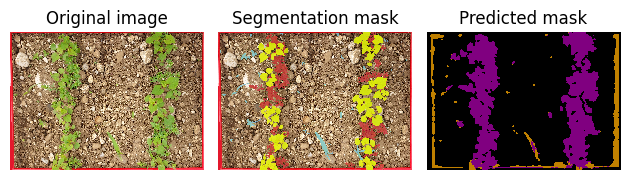

In [29]:
def predict_single_image(image_path):
    
    image = Image.open(image_path).convert("RGB")
    orig_w, orig_h = image.size 
    input_tensor = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(input_tensor)
        mask = torch.argmax(output, dim=1)

        # --- UPSAMPLING ALLA DIMENSIONE ORIGINALE ---
        mask = mask.unsqueeze(1).float()
        mask_up = F.interpolate(mask, size=(orig_h, orig_w), mode='nearest').squeeze().long().cpu().numpy()

    # Decodifica maschera con colori
    full_mask = remap_mask(mask_up, remap)
    color_mask = decode_segmap(full_mask)

    annotated_path = os.path.join(os.path.dirname(image_path), "annotated_image.png")
    annotated_image = Image.open(annotated_path).convert("RGB")

    # Visualizza immagine originale + maschera colorata
    plt.subplot(1, 3, 1)
    plt.imshow(image, interpolation="none")
    plt.title("Original image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(annotated_image, interpolation="none")
    plt.title("Segmentation mask")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(color_mask, interpolation="none")
    plt.title("Predicted mask")
    plt.axis("off")

    plt.tight_layout()
    plt.savefig("naive_prediction.png", dpi=300, bbox_inches="tight")
    plt.show()
    
image_path = "../images/output_18_A/clean_image.png"   #3146x2235
predict_single_image(image_path)

In [6]:
def predict_mask(image_path):
    """Predice la maschera rimappata (0=soil, 1=buckwheat, 2=weeds, 3=others)."""
    image = Image.open(image_path).convert("RGB")
    orig_w, orig_h = image.size 
    input_tensor = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(input_tensor)
        mask = torch.argmax(output, dim=1)

        # Upsampling alla dimensione originale
        mask = mask.unsqueeze(1).float()
        mask_up = F.interpolate(mask, size=(orig_h, orig_w), mode='nearest').squeeze().long().cpu().numpy()

    return remap_mask(mask_up, remap)

In [12]:
def load_ground_truth_masks(folder):
    """Costruisce la ground truth per soil, buckwheat e weeds a partire dalle maschere se presenti.
       Se una maschera non esiste, viene considerata tutta vuota.
    """
    # Percorsi
    buckwheat_path = os.path.join(folder, "mask[Grano saraceno].png")
    weeds_path = os.path.join(folder, "mask[Infestante].png")

    # Carica la maschera delle infestanti (obbligatoria)
    weeds_mask = np.array(Image.open(weeds_path).convert("L"))

    # Se la maschera del grano non esiste → maschera vuota
    if os.path.exists(buckwheat_path):
        buckwheat_mask = np.array(Image.open(buckwheat_path).convert("L"))
    else:
        buckwheat_mask = np.zeros_like(weeds_mask, dtype=np.uint8)

    # Binarizzazione
    buckwheat_bin = (buckwheat_mask > 0).astype(np.int64)
    weeds_bin = (weeds_mask > 0).astype(np.int64)

    # Soil = tutto ciò che non è buckwheat né weeds
    soil_bin = (1 - np.clip(buckwheat_bin + weeds_bin, 0, 1)).astype(np.int64)

    # Maschera finale
    gt_mask = np.zeros_like(soil_bin, dtype=np.int64)
    gt_mask[soil_bin == 1] = 0  # soil
    gt_mask[buckwheat_bin == 1] = 1  # buckwheat
    gt_mask[weeds_bin == 1] = 2  # weeds
    return gt_mask

In [13]:
def compute_metrics(y_true, y_pred, num_classes=3):
    """Calcola precision, recall, IoU e F1 per ciascuna classe, gestendo il caso di classe assente."""
    metrics = {}
    for c in range(num_classes):
        tp = np.sum((y_pred == c) & (y_true == c))
        fp = np.sum((y_pred == c) & (y_true != c))
        fn = np.sum((y_pred != c) & (y_true == c))

        # Caso speciale: classe assente nella GT
        if np.sum(y_true == c) == 0:
            if fp == 0:
                # Modello ha predetto correttamente "nessuna presenza" -> punteggio perfetto
                precision = recall = iou = f1 = 1.0
            else:
                # Modello ha predetto falsi positivi -> penalizzazione totale
                precision = recall = iou = f1 = 0.0
        else:
            precision = tp / (tp + fp + 1e-8)
            recall = tp / (tp + fn + 1e-8)
            iou = tp / (tp + fp + fn + 1e-8)
            f1 = 2 * precision * recall / (precision + recall + 1e-8)

        metrics[c] = {
            "precision": precision,
            "recall": recall,
            "iou": iou,
            "f1": f1
        }
    return metrics

In [14]:
all_times = []

# Classi
class_names = ["Soil", "Buckwheat", "Weeds"]

# 🔧 Calcolo dei GFLOPs una sola volta
# Assumendo che il tuo modello sia definito come "model"
# e che accetti input con dimensioni (1, 3, H, W)
model_cpu = model.to("cpu")
dummy_input = torch.randn(1, 3, 512, 512)  # modifica le dimensioni se necessario
macs, params = profile(model, inputs=(dummy_input,), verbose=False)
gflops = macs / 1e9  # conversione MACs → GFLOPs (1 GFLOP = 10^9 MACs)

print(f"\n⚙️  Stima GFLOPs modello: {gflops:.2f} GFLOPs")

# Itera su tutte le cartelle da output_1_A a output_20_B
for x in range(1, 21):
    for suffix in ["A", "B"]:
        folder = f"../images/output_{x}_{suffix}/"
        image_path = os.path.join(folder, "clean_image.png")
        
        if not os.path.exists(image_path):
            print(f"[SKIP] Immagine mancante in {folder}")
            continue

        # 1️⃣ Tempo di inferenza
        start_time = time.time()
        pred_mask = predict_mask(image_path)
        end_time = time.time()

        inference_time = end_time - start_time
        all_times.append(inference_time)

        print(f"📂 Cartella: {folder}")
        print(f"  ⏱️ Tempo inferenza: {inference_time:.4f} s")

# --- 📊 Risultati finali ---
if all_times:
    avg_time = np.mean(all_times)
    print("\n====================")
    print("📊 RISULTATI GLOBALI")
    print("====================")
    print(f"⏱️ Tempo medio di inferenza per immagine: {avg_time:.4f} s")
    print(f"🧮 GFLOPs richiesti: {gflops:.2f} GFLOPs")
else:
    print("\n⚠️ Nessuna inferenza eseguita: controlla che le cartelle e le immagini esistano.")



⚙️  Stima GFLOPs modello: 10.81 GFLOPs
📂 Cartella: ../images/output_1_A/
  ⏱️ Tempo inferenza: 0.3140 s
📂 Cartella: ../images/output_1_B/
  ⏱️ Tempo inferenza: 0.2914 s
📂 Cartella: ../images/output_2_A/
  ⏱️ Tempo inferenza: 0.3120 s
📂 Cartella: ../images/output_2_B/
  ⏱️ Tempo inferenza: 0.3209 s
📂 Cartella: ../images/output_3_A/
  ⏱️ Tempo inferenza: 0.3096 s
📂 Cartella: ../images/output_3_B/
  ⏱️ Tempo inferenza: 0.3149 s
📂 Cartella: ../images/output_4_A/
  ⏱️ Tempo inferenza: 0.3116 s
📂 Cartella: ../images/output_4_B/
  ⏱️ Tempo inferenza: 0.3214 s
📂 Cartella: ../images/output_5_A/
  ⏱️ Tempo inferenza: 0.2855 s
📂 Cartella: ../images/output_5_B/
  ⏱️ Tempo inferenza: 0.3202 s
📂 Cartella: ../images/output_6_A/
  ⏱️ Tempo inferenza: 0.3097 s
📂 Cartella: ../images/output_6_B/
  ⏱️ Tempo inferenza: 0.3144 s
📂 Cartella: ../images/output_7_A/
  ⏱️ Tempo inferenza: 0.3022 s
📂 Cartella: ../images/output_7_B/
  ⏱️ Tempo inferenza: 0.3074 s
📂 Cartella: ../images/output_8_A/
  ⏱️ Tempo infer